# DL_HW2

In [1]:
import numpy as np
import pandas as pd
import time, os, pickle, json, random

from imageio import imread, imwrite
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm, trange
import multiprocessing
from multiprocessing import Pool
from skimage import feature, data, color
import skimage
import cv2
from functools import partial
from sklearn import preprocessing
from sklearn.linear_model import Perceptron

from abc import ABCMeta, abstractmethod

cpus = multiprocessing.cpu_count()
print(cpus)
%autosave 120

160


Autosaving every 120 seconds


## Tool Box

In [2]:
# onehot
def self_onehot(x, c = 50) : 
    x_onehot = np.zeros([x.shape[0], c])
    for i in range(x.shape[0]) :
        x_onehot[i, int(x[i])] = 1
    return x_onehot

# 讀取圖片function
def read_img(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (256, 256))
    return img

# color histogram
def color_histogram(img, hist_size = 256):
    img = img.astype(np.uint8)
    color = ('b','g','r')
    histogram = []
    for idx, color in enumerate(color):
        h = cv2.calcHist(img,[idx],None,[hist_size],[0, 256])
        histogram.append(h)
    return np.array(histogram).squeeze().reshape(1, -1)
# histogram of gradient
def get_hog_feature(img) :
    img = img.astype(np.uint8)
    hog_vec, hog_vis = feature.hog(img, 
                               pixels_per_cell=(64, 64), 
                               cells_per_block = [1, 1],
                               channel_axis = 2, 
                               visualize=True)
    return hog_vec

# haralick
def get_haralick(img): 
    values_temp = []
    img = img.astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    glcm = skimage.feature.graycomatrix(img, [2, 8, 16], [0, np.pi / 4, np.pi / 2, np.pi * 3 / 4], 256, symmetric=True, normed=True)  # , np.pi / 4, np.pi / 2, np.pi * 3 / 4
    # print(glcm.shape) 
    for prop in {'contrast', 'dissimilarity','homogeneity', 'energy', 'correlation', 'ASM'}:
        temp = skimage.feature.graycoprops(glcm, prop)
        temp = np.array(temp).reshape(-1)
        values_temp.append(temp)
        # print(prop, temp)
        # print('len:',len(temp))
        # print('')
    values_temp = np.array(values_temp).reshape(1, -1)
    return (values_temp)

## Read Data and Feature Extraction

In [3]:
# 讀取index
os.chdir('/home/rita/111/111-2DL/HW1')
train_idx = pd.read_table('train.txt', header = None, sep = ' ')
val_idx = pd.read_table('val.txt', header = None, sep = ' ')
test_idx = pd.read_table('test.txt', header = None, delimiter = ' ')
train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
test_idx = np.array(test_idx)
train_y = train_idx[::, 1].astype(float)
val_y = val_idx[::, 1].astype(float)
test_y = test_idx[::, 1].astype(float)
os.chdir('/home/rita/111/111-2DL/HW2')

In [4]:
# 讀取圖片
# 40 s
os.chdir('/home/rita/111/111-2DL/HW1')
s = time.time()
if __name__ == '__main__' : 
    with Pool(processes = 80) as p:
        train_pic = list(tqdm(p.imap(read_img, train_idx[::, 0], chunksize=100), total = train_idx.shape[0]))
        val_pic = list(tqdm(p.imap(read_img, val_idx[::, 0], chunksize=100), total = val_idx.shape[0]))
        test_pic = list(tqdm(p.imap(read_img, test_idx[::, 0], chunksize=100), total = test_idx.shape[0]))
os.chdir('/home/rita/111/111-2DL/HW2')

train_pic_list = train_pic
val_pic_list = val_pic
test_pic_list = test_pic

train_pic = np.array(train_pic)
val_pic = np.array(val_pic)
test_pic = np.array(test_pic)

np.save('./data/train_pic', train_pic)
np.save('./data/val_pic', val_pic)
np.save('./data/test_pic', test_pic)

func = partial(color_histogram, hist_size = 64)
with Pool(processes = 40) as p:
    train_x_color_hist = list(tqdm(p.imap(func, train_pic_list, chunksize=1000), total = train_idx.shape[0]))
    val_x_color_hist = list(tqdm(p.imap(func, val_pic_list, chunksize=100), total = val_idx.shape[0]))
    test_x_color_hist = list(tqdm(p.imap(func, test_pic_list, chunksize=100), total = test_idx.shape[0]))
train_x_color_hist = np.array(train_x_color_hist).squeeze()
val_x_color_hist = np.array(val_x_color_hist).squeeze()
test_x_color_hist = np.array(test_x_color_hist).squeeze()

with Pool(processes = 40) as p:
    train_x_hog = list(tqdm(p.imap(get_hog_feature, train_pic_list, chunksize=100), total = train_idx.shape[0]))
    val_x_hog = list(tqdm(p.imap(get_hog_feature, val_pic_list, chunksize=100), total = val_idx.shape[0]))
    test_x_hog = list(tqdm(p.imap(get_hog_feature, test_pic_list, chunksize=100), total = test_idx.shape[0])) 
train_x_hog = np.array(train_x_hog)
val_x_hog = np.array(val_x_hog)
test_x_hog = np.array(test_x_hog)

with Pool(40) as p:
    train_x_haralick = list(tqdm(p.imap(get_haralick, train_pic_list, chunksize=100), total = train_idx.shape[0]))
    val_x_haralick = list(tqdm(p.imap(get_haralick, val_pic_list, chunksize=100), total = val_idx.shape[0]))
    test_x_haralick = list(tqdm(p.imap(get_haralick, test_pic_list, chunksize=100), total = test_idx.shape[0])) 
train_x_haralick = np.array(train_x_haralick).squeeze()
val_x_haralick = np.array(val_x_haralick).squeeze()
test_x_haralick = np.array(test_x_haralick).squeeze()

train_x = np.concatenate([train_x_color_hist, train_x_hog, train_x_haralick], axis = 1)
val_x = np.concatenate([val_x_color_hist, val_x_hog, val_x_haralick], axis = 1)
test_x = np.concatenate([test_x_color_hist, test_x_hog, test_x_haralick], axis = 1)

np.save('./data/train_x', train_x)
np.save('./data/val_x', val_x)
np.save('./data/test_x', test_x)
print(time.time() - s)

100%|██████████| 450/450 [00:07<00:00, 56.68it/s]


348.76488161087036


In [5]:
# 讀取index
os.chdir('/home/rita/111/111-2DL/HW1')
train_idx = pd.read_table('train.txt', header = None, sep = ' ')
val_idx = pd.read_table('val.txt', header = None, sep = ' ')
test_idx = pd.read_table('test.txt', header = None, delimiter = ' ')
train_idx = np.array(train_idx)
val_idx = np.array(val_idx)
test_idx = np.array(test_idx)
train_y = train_idx[::, 1].astype(float)
val_y = val_idx[::, 1].astype(float)
test_y = test_idx[::, 1].astype(float)
os.chdir('/home/rita/111/111-2DL/HW2')

In [6]:
train_y_onehot = self_onehot(train_y)
val_y_onehot = self_onehot(val_y)
test_y_onehot = self_onehot(test_y)

In [7]:
train_pic = np.load('./data/train_pic.npy')
val_pic = np.load('./data/val_pic.npy')
test_pic = np.load('./data/test_pic.npy')
train_x = np.load('./data/train_x.npy')
val_x = np.load('./data/val_x.npy')
test_x = np.load('./data/test_x.npy')

## Multilayer Perceptron

In [8]:
class Self_DataLoader() :
    def __init__(self, data, label, batch_size = 64, shuffle = False) :
        self.data = data
        self.label = label
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.n_sample = data.shape[0]
        self.n_batches = (self.n_sample // self.batch_size) # + 1
        self.start = 0
        self.end = self.start + self.batch_size
        if self.shuffle : np.random.shuffle(np.arange(self.n_sample))
                
    def __iter__(self):
        return self
        
    def __next__(self):
        if self.end >= self.n_sample :
            self.start = 0
            self.end = self.start + self.batch_size
            if self.shuffle : np.random.shuffle(np.arange(self.n_sample))
            raise StopIteration
        datas = self.data[self.start : self.end]
        labels = self.label[self.start : self.end]
        
        self.start += self.batch_size
        self.end += self.batch_size
        return datas, labels

In [9]:
class self_MLP() :
    def __init__(self, n_input, n_output, n_hidden, n_epochs, learning_rate) :
        self.n_input = n_input
        self.n_output = n_output
        self.n_hidden = n_hidden
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        # he initialization  
        self.w1 = np.random.randn(self.n_input, self.n_hidden) * np.sqrt(2 / self.n_input)
        self.b1 = np.zeros((1, self.n_hidden))
        self.w2 = np.random.randn(self.n_hidden, self.n_output) * np.sqrt(2 / self.n_hidden)
        self.b2 = np.zeros((1, self.n_output))
        
    def forward(self, x) :
        # nf * fh + 1h = nh
        self.z1 = np.dot(x, self.w1) + self.b1 
        self.a1 = self.softmax(self.z1)           
        # nh * ho + 1o = no
        self.z2 = np.dot(self.a1, self.w2) + self.b2 
        self.y_hat = self.softmax(self.z2)            # y
        # no
        return self.y_hat
        
    def backward(self, x, y) :
        # no
        dy = self.y_hat - y
        # ho = hn * no
        dw2 = np.dot(self.a1.T, dy)
        # 1o = no.sum
        db2 = np.sum(dy, axis = 0, keepdims = True)
        # nh = no * oh 
        ds = np.dot(dy, self.w2.T) * self.a1 * (1 - self.a1)
        # fh = fn *    nh
        dw1 = np.dot(np.transpose(x), ds)
        # 1h = nh.sum
        db1 = np.sum(ds, axis=0, keepdims=True)
        
        self.w1 -= self.learning_rate * dw1
        self.b1 -= self.learning_rate * db1
        self.w2 -= self.learning_rate * dw2
        self.b2 -= self.learning_rate * db2
        
    def loss_fn(self, y_hat, y) :
        n = y.shape[0]
        temp = np.mean(-np.sum(y * np.log(y_hat), axis = 1))
        return temp
        # return temp.squeeze()
        
    def softmax(self, x) :
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims = True)
    
    def train(self, dataloader) : 
        ls_loss = []
        
        for epoch in trange(1, n_epochs + 1) :

            for x, y in dataloader : 
                y_hat = self.forward(x)
                loss = self.loss_fn(y_hat, y)
                self.backward(x, y)
            # if(epoch % 1 == 0) : print('Epochs : ', epoch, ' Loss : ', loss)
            ls_loss.append(loss)
        return ls_loss
    
    def predict(self, x) :
        y_hat = self.forward(x)
        # return y_hat
        return np.argmax(y_hat, axis = 1)     

In [10]:
n_input = train_x.shape[1]
n_output = 50
n_hidden = 128
n_epochs = 200
learning_rate = 1e-4
model = self_MLP(
    n_input = n_input, 
    n_output = n_output, 
    n_hidden = n_hidden, 
    n_epochs = n_epochs, 
    learning_rate = learning_rate
)
trainx = preprocessing.scale(train_x)
train_dataloader = Self_DataLoader(trainx, train_y_onehot, batch_size = 128, shuffle=True)
ls_loss = model.train(train_dataloader)

filename = './model/TwoLayerPerceptron.sav'
pickle.dump(model, open(filename, 'wb'))

with open("loss.txt", "w") as fp:
    json.dump(ls_loss, fp)

100%|██████████| 200/200 [02:51<00:00,  1.17it/s]


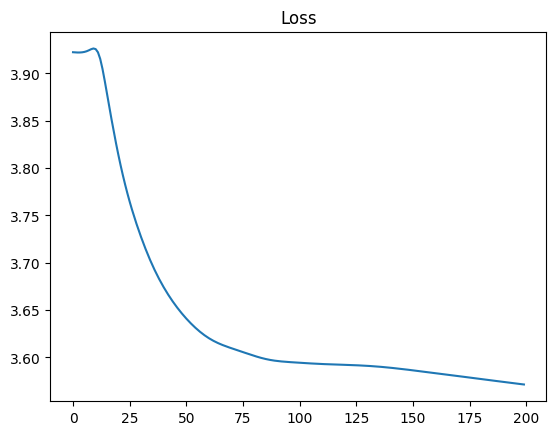

In [14]:
filename = './model/TwoLayerPerceptron.sav'
loaded_model = pickle.load(open(filename, 'rb'))

with open("loss.txt", "r") as fp:
    ls_loss = json.load(fp)
    
fig = plt.figure()
plt.title('Loss')
temp = np.array(ls_loss)
plt.plot(range(len(ls_loss)), temp)
# plt.savefig('./figure/loss.png')
# plt.close(fig)
plt.show()

In [15]:
trainx = preprocessing.scale(train_x)
pred_y = loaded_model.predict(trainx)
acc = np.mean(pred_y == train_y)
print('Train Accuracy : ', acc)
valx = preprocessing.scale(val_x)
pred_y = loaded_model.predict(valx)
acc = np.mean(pred_y == val_y)
print('val Accuracy : ', acc)
testx = preprocessing.scale(test_x)
pred_y = loaded_model.predict(testx)
acc = np.mean(pred_y == test_y)
print('Test Accuracy : ', acc)

Train Accuracy :  0.05768653770232925
val Accuracy :  0.05333333333333334
Test Accuracy :  0.05555555555555555


### Compare with sklearn Perceptron

In [16]:
clf = Perceptron(tol=1e-5, n_jobs = 40, early_stopping = True, warm_start = True, max_iter = 2000)
clf.fit(train_x, train_y)

print('訓練集: ', clf.score(train_x, train_y))
print('驗證集: ', clf.score(val_x, val_y))
print('測試集: ', clf.score(test_x, test_y))

訓練集:  0.05009080142123964
驗證集:  0.051111111111111114
測試集:  0.044444444444444446


## Lenet5

In [17]:
# reference : https://github.com/toxtli/lenet-5-mnist-from-scratch-numpy/blob/master/app.py

# def MakeOneHot(Y, D_out):
#     N = Y.shape[0]
#     Z = np.zeros((N, D_out))
#     Z[np.arange(N), Y] = 1
#     return Z



def draw_losses(losses):
    t = np.arange(len(losses))
    plt.plot(t, losses)
    plt.show()

def get_batch(X, Y, batch_size):
    N = len(X)
    i = random.randint(1, N-batch_size)
    return X[i:i+batch_size], Y[i:i+batch_size]

class FC():
    def __init__(self, D_in, D_out):
        self.cache = None
        self.W = {'val': np.random.normal(0.0, np.sqrt(2/D_in), (D_in,D_out)), 'grad': 0}
        self.b = {'val': np.random.randn(D_out), 'grad': 0}

    def _forward(self, X):
        out = np.dot(X, self.W['val']) + self.b['val']
        self.cache = X
        return out

    def _backward(self, dout):
        X = self.cache
        dX = np.dot(dout, self.W['val'].T).reshape(X.shape)
        self.W['grad'] = np.dot(X.reshape(X.shape[0], np.prod(X.shape[1:])).T, dout)
        self.b['grad'] = np.sum(dout, axis=0)
        #self._update_params()
        return dX

    def _update_params(self, lr=0.001):
        # Update the parameters
        self.W['val'] -= lr*self.W['grad']
        self.b['val'] -= lr*self.b['grad']

class ReLU():
    def __init__(self):
        self.cache = None

    def _forward(self, X):
        out = np.maximum(0, X)
        self.cache = X
        return out

    def _backward(self, dout):
        X = self.cache
        dX = np.array(dout, copy=True)
        dX[X <= 0] = 0
        return dX

class Softmax():
    """
    Softmax activation layer
    """
    def __init__(self):
        #print("Build Softmax")
        self.cache = None

    def _forward(self, X):
        #print("Softmax: _forward")
        maxes = np.amax(X, axis=1)
        maxes = maxes.reshape(maxes.shape[0], 1)
        Y = np.exp(X - maxes)
        Z = Y / np.sum(Y, axis=1).reshape(Y.shape[0], 1)
        self.cache = (X, Y, Z)
        return Z # distribution

    def _backward(self, dout):
        X, Y, Z = self.cache
        dZ = np.zeros(X.shape)
        dY = np.zeros(X.shape)
        dX = np.zeros(X.shape)
        N = X.shape[0]
        for n in range(N):
            i = np.argmax(Z[n])
            dZ[n,:] = np.diag(Z[n]) - np.outer(Z[n],Z[n])
            M = np.zeros((N,N))
            M[:,i] = 1
            dY[n,:] = np.eye(N) - M
        dX = np.dot(dout,dZ)
        dX = np.dot(dX,dY)
        return dX
    
    
class Conv():
    def __init__(self, Cin, Cout, F, stride=1, padding=0, bias=True):
        self.Cin = Cin
        self.Cout = Cout
        self.F = F
        self.S = stride
        self.W = {'val': np.random.normal(0.0,np.sqrt(2/Cin),(Cout,Cin,F,F)), 'grad': 0} # Xavier Initialization
        self.b = {'val': np.random.randn(Cout), 'grad': 0}
        self.cache = None
        self.pad = padding

    def _forward(self, X):
        X = np.pad(X, ((0,0),(0,0),(self.pad,self.pad),(self.pad,self.pad)), 'constant')
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + 1
        W_ = W - self.F + 1
        Y = np.zeros((N, self.Cout, H_, W_))

        for n in range(N):
            for c in range(self.Cout):
                for h in range(H_):
                    for w in range(W_):
                        Y[n, c, h, w] = np.sum(X[n, :, h:h+self.F, w:w+self.F] * self.W['val'][c, :, :, :]) + self.b['val'][c]

        self.cache = X
        return Y

    def _backward(self, dout):
        # dout (N,Cout,H_,W_)
        # W (Cout, Cin, F, F)
        X = self.cache
        (N, Cin, H, W) = X.shape
        H_ = H - self.F + 1
        W_ = W - self.F + 1
        W_rot = np.rot90(np.rot90(self.W['val']))

        dX = np.zeros(X.shape)
        dW = np.zeros(self.W['val'].shape)
        db = np.zeros(self.b['val'].shape)

        # dW
        for co in range(self.Cout):
            for ci in range(Cin):
                for h in range(self.F):
                    for w in range(self.F):
                        dW[co, ci, h, w] = np.sum(X[:,ci,h:h+H_,w:w+W_] * dout[:,co,:,:])

        # db
        for co in range(self.Cout):
            db[co] = np.sum(dout[:,co,:,:])

        dout_pad = np.pad(dout, ((0,0),(0,0),(self.F,self.F),(self.F,self.F)), 'constant')
        #print("dout_pad.shape: " + str(dout_pad.shape))
        # dX
        for n in range(N):
            for ci in range(Cin):
                for h in range(H):
                    for w in range(W):
                        #print("self.F.shape: %s", self.F)
                        #print("%s, W_rot[:,ci,:,:].shape: %s, dout_pad[n,:,h:h+self.F,w:w+self.F].shape: %s" % ((n,ci,h,w),W_rot[:,ci,:,:].shape, dout_pad[n,:,h:h+self.F,w:w+self.F].shape))
                        dX[n, ci, h, w] = np.sum(W_rot[:,ci,:,:] * dout_pad[n, :, h:h+self.F,w:w+self.F])

        return dX

class MaxPool():
    def __init__(self, F, stride):
        self.F = F
        self.S = stride
        self.cache = None

    def _forward(self, X):
        # X: (N, Cin, H, W): maxpool along 3rd, 4th dim
        (N,Cin,H,W) = X.shape
        F = self.F
        W_ = int(float(W)/F)
        H_ = int(float(H)/F)
        Y = np.zeros((N,Cin,W_,H_))
        M = np.zeros(X.shape) # mask
        for n in range(N):
            for cin in range(Cin):
                for w_ in range(W_):
                    for h_ in range(H_):
                        Y[n,cin,w_,h_] = np.max(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)])
                        i,j = np.unravel_index(X[n,cin,F*w_:F*(w_+1),F*h_:F*(h_+1)].argmax(), (F,F))
                        M[n,cin,F*w_+i,F*h_+j] = 1
        self.cache = M
        return Y

    def _backward(self, dout):
        M = self.cache
        (N,Cin,H,W) = M.shape
        dout = np.array(dout)
        #print("dout.shape: %s, M.shape: %s" % (dout.shape, M.shape))
        dX = np.zeros(M.shape)
        for n in range(N):
            for c in range(Cin):
                #print("(n,c): (%s,%s)" % (n,c))
                dX[n,c,:,:] = dout[n,c,:,:].repeat(2, axis=0).repeat(2, axis=1)
        return dX*M

def NLLLoss(Y_pred, Y_true):
    """
    Negative log likelihood loss
    """
    loss = 0.0
    N = Y_pred.shape[0]
    M = np.sum(Y_pred*Y_true, axis=1)
    for e in M:
        #print(e)
        if e == 0:
            loss += 500
        else:
            loss += -np.log(e)
    return loss/N
    
class CrossEntropyLoss():
    def __init__(self):
        pass

    def get(self, Y_pred, Y_true):
        N = Y_pred.shape[0]
        softmax = Softmax()
        prob = softmax._forward(Y_pred)
        loss = NLLLoss(prob, Y_true)
        Y_serial = np.argmax(Y_true, axis=1)
        dout = prob.copy()
        dout[np.arange(N), Y_serial] -= 1
        return loss, dout

class Net(metaclass=ABCMeta):
    # Neural network super class

    @abstractmethod
    def __init__(self):
        pass

    @abstractmethod
    def forward(self, X):
        pass

    @abstractmethod
    def backward(self, dout):
        pass

    @abstractmethod
    def get_params(self):
        pass

    @abstractmethod
    def set_params(self, params):
        pass

class SGD():
    def __init__(self, params, lr=0.001, reg=0):
        self.parameters = params
        self.lr = lr
        self.reg = reg

    def step(self):
        for param in self.parameters:
            param['val'] -= (self.lr*param['grad'] + self.reg*param['val'])
    
class SGDMomentum():
    def __init__(self, params, lr=0.001, momentum=0.99, reg=0):
        self.l = len(params)
        self.parameters = params
        self.velocities = []
        for param in self.parameters:
            self.velocities.append(np.zeros(param['val'].shape))
        self.lr = lr
        self.rho = momentum
        self.reg = reg

    def step(self):
        for i in range(self.l):
            self.velocities[i] = self.rho*self.velocities[i] + (1-self.rho)*self.parameters[i]['grad']
            self.parameters[i]['val'] -= (self.lr*self.velocities[i] + self.reg*self.parameters[i]['val'])

def softmax(self, x) :
        return np.exp(x) / np.sum(np.exp(x), axis=1, keepdims = True)
            

### test for mnist 

In [18]:
class LeNet5(Net):
    # LeNet5

    def __init__(self):
        self.conv1 = Conv(1, 6, 5) # C1(1*32*32 --> 6*28*28)
        self.ReLU1 = ReLU()
        self.pool1 = MaxPool(2,2) # S2(6*28*28  --> 6*14*14)
        self.conv2 = Conv(6, 16, 5) # C3(6*14*14 --> 16*10*10)
        self.ReLU2 = ReLU()
        self.pool2 = MaxPool(2,2) # S4(16*5*5)
        self.FC1 = FC(16*4*4, 120) # C5()
        self.ReLU3 = ReLU()
        self.FC2 = FC(120, 84) # F6
        self.ReLU4 = ReLU()
        self.FC3 = FC(84, 10)
        self.Softmax = Softmax()

        self.p2_shape = None

    def forward(self, X):
        h1 = self.conv1._forward(X)
        a1 = self.ReLU1._forward(h1)
        p1 = self.pool1._forward(a1)
        h2 = self.conv2._forward(p1)
        a2 = self.ReLU2._forward(h2)
        p2 = self.pool2._forward(a2)
        self.p2_shape = p2.shape
        fl = p2.reshape(X.shape[0],-1) # Flatten
        h3 = self.FC1._forward(fl)
        a3 = self.ReLU3._forward(h3)
        h4 = self.FC2._forward(a3)
        a5 = self.ReLU4._forward(h4)
        h5 = self.FC3._forward(a5)
        a5 = self.Softmax._forward(h5)
        return a5

    def backward(self, dout):
        #dout = self.Softmax._backward(dout)
        dout = self.FC3._backward(dout)
        dout = self.ReLU4._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.ReLU3._backward(dout)
        dout = self.FC1._backward(dout)
        dout = dout.reshape(self.p2_shape) # reshape
        dout = self.pool2._backward(dout)
        dout = self.ReLU2._backward(dout)
        dout = self.conv2._backward(dout)
        dout = self.pool1._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.conv1._backward(dout)

    def get_params(self):
        return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params

In [ ]:
filename = [
	["training_images","train-images-idx3-ubyte.gz"],
	["test_images","t10k-images-idx3-ubyte.gz"],
	["training_labels","train-labels-idx1-ubyte.gz"],
	["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1]+"...")
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1,28*28)
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            mnist[name[0]] = np.frombuffer(f.read(), np.uint8, offset=8)
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def init():
    download_mnist()
    save_mnist()

def load():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

class ThreeLayerNet(Net):

    #Simple 3 layer NN

    def __init__(self, N, D_in, H1, H2, D_out, weights=''):
        self.FC1 = FC(D_in, H1)
        self.ReLU1 = ReLU()
        self.FC2 = FC(H1, H2)
        self.ReLU2 = ReLU()
        self.FC3 = FC(H2, D_out)

        if weights == '':
            pass
        else:
            with open(weights,'rb') as f:
                params = pickle.load(f)
                self.set_params(params)

    def forward(self, X):
        h1 = self.FC1._forward(X)
        a1 = self.ReLU1._forward(h1)
        h2 = self.FC2._forward(a1)
        a2 = self.ReLU2._forward(h2)
        h3 = self.FC3._forward(a2)
        return h3

    def backward(self, dout):
        dout = self.FC3._backward(dout)
        dout = self.ReLU2._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.FC1._backward(dout)

    def get_params(self):
        return [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params

def MakeOneHot(Y, D_out):
    N = Y.shape[0]
    Z = np.zeros((N, D_out))
    Z[np.arange(N), Y] = 1
    return Z

def draw_losses(losses):
    t = np.arange(len(losses))
    plt.plot(t, losses)
    plt.show()

def get_batch(X, Y, batch_size):
    N = len(X)
    i = random.randint(1, N-batch_size)
    return X[i:i+batch_size], Y[i:i+batch_size]

#mnist.init()
X_train, Y_train, X_test, Y_test = load()
X_train, X_test = X_train/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_test -= np.mean(X_test)

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

print(X_train.shape)
batch_size = 64
D_in = 784
D_out = 10

print("batch_size: " + str(batch_size) + ", D_in: " + str(D_in) + ", D_out: " + str(D_out))

### TWO LAYER NET FORWARD TEST ###
#H=400
#model = nn.TwoLayerNet(batch_size, D_in, H, D_out)
# H1=300
# H2=100
# model = ThreeLayerNet(batch_size, D_in, H1, H2, D_out)
model = LeNet5()

losses = []
#optim = optimizer.SGD(model.get_params(), lr=0.0001, reg=0)
optim = SGDMomentum(model.get_params(), lr=0.0001, momentum=0.80, reg=0.00003)
criterion = CrossEntropyLoss()

# TRAIN
ITER = 25
for i in trange(ITER):
	# get batch, make onehot
	X_batch, Y_batch = get_batch(X_train, Y_train, batch_size)
	Y_batch = MakeOneHot(Y_batch, D_out)

	# forward, loss, backward, step
	Y_pred = model.forward(X_batch)
	loss, dout = criterion.get(Y_pred, Y_batch)
	model.backward(dout)
	optim.step()

	if i % 10 == 0:
		print("%s%% iter: %s, loss: %s" % (100*i/ITER,i, loss))
	losses.append(loss)


draw_losses(losses)


### test

In [19]:
class LeNet5(Net):
    # LeNet5

    def __init__(self):
        self.conv1 = Conv(3, 6, 5) # C1(1*32*32 --> 6*28*28)
        self.ReLU1 = ReLU()
        self.pool1 = MaxPool(2,2) # S2(6*28*28  --> 6*14*14)
        self.conv2 = Conv(6, 16, 5) # C3(6*14*14 --> 16*10*10)
        self.ReLU2 = ReLU()
        self.pool2 = MaxPool(2,2) # S4(16*5*5)
        self.FC1 = FC(16*5*5, 120) # C5()
        self.ReLU3 = ReLU()
        self.FC2 = FC(120, 84) # F6
        self.ReLU4 = ReLU()
        self.FC3 = FC(84, 50)
        self.Softmax = Softmax()

        self.p2_shape = None

    def forward(self, X):
        h1 = self.conv1._forward(X)
        a1 = self.ReLU1._forward(h1)
        p1 = self.pool1._forward(a1)
        h2 = self.conv2._forward(p1)
        a2 = self.ReLU2._forward(h2)
        p2 = self.pool2._forward(a2)
        self.p2_shape = p2.shape
        fl = p2.reshape(X.shape[0],-1) # Flatten
        h3 = self.FC1._forward(fl)
        a3 = self.ReLU3._forward(h3)
        h4 = self.FC2._forward(a3)
        a5 = self.ReLU4._forward(h4)
        h5 = self.FC3._forward(a5)
        a5 = self.Softmax._forward(h5)
        return a5

    def backward(self, dout):
        #dout = self.Softmax._backward(dout)
        dout = self.FC3._backward(dout)
        dout = self.ReLU4._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.ReLU3._backward(dout)
        dout = self.FC1._backward(dout)
        dout = dout.reshape(self.p2_shape) # reshape
        dout = self.pool2._backward(dout)
        dout = self.ReLU2._backward(dout)
        dout = self.conv2._backward(dout)
        dout = self.pool1._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.conv1._backward(dout)

    def get_params(self):
        return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params

In [20]:
# 讀取圖片function
def read_img_32(path) :
    img = cv2.imread(path)
    img = cv2.resize(img, (32, 32))
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img
os.chdir('/home/rita/111/111-2DL/HW1')
if __name__ == '__main__' : 
    with Pool(processes = 80) as p:
        train_pic_32 = list(tqdm(p.imap(read_img_32, train_idx[::, 0], chunksize=100), total = train_idx.shape[0]))
        val_pic_32 = list(tqdm(p.imap(read_img_32, val_idx[::, 0], chunksize=100), total = val_idx.shape[0]))
        test_pic_32 = list(tqdm(p.imap(read_img_32, test_idx[::, 0], chunksize=100), total = test_idx.shape[0]))
os.chdir('/home/rita/111/111-2DL/HW2')

train_pic_32 = np.array(train_pic_32)
val_pic_32 = np.array(val_pic_32)
test_pic_32 = np.array(test_pic_32)

X_train, Y_train, X_test, Y_test = train_pic_32, train_y_onehot, test_pic_32, test_y_onehot
X_val, Y_val = val_pic_32, val_y_onehot
X_train, X_val, X_test = X_train/float(255), X_val/float(255), X_test/float(255)
X_train -= np.mean(X_train)
X_val -= np.mean(X_val)
X_test -= np.mean(X_test)
X_train = np.transpose(X_train, (0, 3, 1, 2))
X_val = np.transpose(X_val, (0, 3, 1, 2))
X_test = np.transpose(X_test, (0, 3, 1, 2))

train_dataloader = Self_DataLoader(X_train, train_y_onehot, batch_size = 32, shuffle=True)
val_dataloader = Self_DataLoader(X_val, val_y_onehot, batch_size = 32, shuffle=True)
test_dataloader = Self_DataLoader(X_test, test_y_onehot, batch_size = 32)

100%|██████████| 450/450 [00:00<00:00, 2984.41it/s]


In [ ]:
train_dataloader = Self_DataLoader(X_train, train_y, batch_size = 128, shuffle=True)
# val_dataloader = Self_DataLoader(X_val, val_y, batch_size = 128, shuffle=True)
# test_dataloader = Self_DataLoader(X_test, test_y, batch_size = 128)

model = LeNet5()
optim = SGD(model.get_params(), lr=0.0001, reg=0)
criterion = CrossEntropyLoss()
print('Start Training !')
# TRAIN
# 加 dataloader 版本
n_epochs = 5
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for i in range(n_epochs):
    # train
    temp_train_loss, temp_train_acc = 0, 0
    with tqdm(total=train_dataloader.n_batches) as pbar:
        for X_batch, Y_batch in train_dataloader :
            Y_batch = self_onehot(Y_batch)
            Y_pred = model.forward(X_batch)
            loss, _ = criterion.get(Y_pred, Y_batch)
            dout = Y_pred - Y_batch  # pred - label
            model.backward(dout)
            optim.step()
            
            pred_y = np.argmax(Y_pred, axis=1)
            acc = np.mean(pred_y == np.argmax(Y_batch, axis=1))
            
            temp_train_loss += loss
            temp_train_acc += acc
             
            pbar.update(1)
    temp_train_loss /= train_dataloader.n_batches   
    temp_train_acc /= train_dataloader.n_batches  
    train_acc.append(temp_train_acc)
    train_loss.append(temp_train_loss)
    
    print("%s%% Epoch: %s, loss: %.5f" % (100*i/n_epochs, i + 1, loss))
    
    # validation
    Y_pred = model.forward(X_val)
    pred_y = np.argmax(Y_pred, axis=1)
    acc = np.mean(pred_y == val_y)
    # Y_batch = self_onehot(Y_val)
    loss, dout = criterion.get(Y_pred, Y_val)
    val_loss.append(loss)
    val_acc.append(acc)

    
# save params
weights = model.get_params()
with open("./model/lenet5.pkl","wb") as f:
    pickle.dump(weights, f)

with open("./loss/train_loss.txt", "w") as fp:
    json.dump(train_loss, fp)
with open("./acc/train_acc.txt", "w") as fp:
    json.dump(train_acc, fp)    
with open("./loss/val_loss.txt", "w") as fp:
    json.dump(val_loss, fp)   
with open("./acc/val_acc.txt", "w") as fp:
    json.dump(val_acc, fp)    
    
# draw
plt.title('Loss')
plt.plot(range(n_epochs), train_loss, label="train")
plt.plot(range(n_epochs), val_loss, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/lenet5_loss.png')
plt.show()

plt.title('Accuracy')
plt.plot(range(n_epochs), train_acc, label="train")
plt.plot(range(n_epochs), val_acc, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/lenet5_acc.png')
plt.show()


Start Training !


100%|██████████| 494/494 [2:20:37<00:00, 17.08s/it]  


0.0% Epoch: 1, loss: 3.81022


100%|██████████| 494/494 [2:18:47<00:00, 16.86s/it]  


20.0% Epoch: 2, loss: 3.79599


100%|██████████| 494/494 [2:18:42<00:00, 16.85s/it]  


40.0% Epoch: 3, loss: 3.81290


 83%|████████▎ | 408/494 [1:56:04<28:54, 20.17s/it]  

In [ ]:
with open("./loss/train_loss.txt", "r") as fp:
    train_loss = json.load(fp)
with open("./acc/val_loss.txt", "r") as fp:
    val_loss = json.load(fp)
with open("./loss/train_acc.txt", "r") as fp:
    train_acc = json.load(fp)
with open("./acc/val_acc.txt", "r") as fp:
    val_acc = json.load(fp)
    
# draw
plt.title('Loss')
plt.plot(range(n_epochs), train_loss, label="train")
plt.plot(range(n_epochs), val_loss, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/lenet5_loss.png')
plt.show()

plt.title('Accuracy')
plt.plot(range(n_epochs), train_acc, label="train")
plt.plot(range(n_epochs), val_acc, label="val", c = 'red')
plt.legend()
plt.savefig('./figure/lenet5_acc.png')
plt.show()

In [ ]:
Y_pred = model.forward(X_test)
pred_y = np.argmax(Y_pred, axis=1)
acc = np.mean(pred_y == test_y)
print('Test Accuracy : ', acc)

In [ ]:
pred_y

### Improved LeNet

In [ ]:
# 自己改的
class Self_Sigmoid():
    def __init__(self):
        self.cache = None

    def _forward(self, X):
        self.cache = 1 / (1 + np.exp(-X))
        return self.cache

    def _backward(self, dout):
        SX = self.cache
        dX = dout*SX*(1-SX)
        return dX


In [ ]:
class Improved_LeNet5(Net):
    # LeNet5

    def __init__(self):
        self.conv1 = Conv(3, 6, 3) # C1(3*32*32 --> 6*30*30)
        self.ReLU1 = ReLU()
        self.pool1 = MaxPool(2,2) # S2(6*30*30  --> 6*15*15)
        self.conv2 = Conv(6, 16, 3) # C3(6*15*15 --> 16*13*13)
        self.ReLU2 = ReLU()
        # 16*13*13 --> 16*14*14
        self.pool2 = MaxPool(2,2) # S4(16*14*14 --> 16*7*7)
        # 16*7*7 -> 16*8*8
        self.conv3 = Conv(16, 6, 3) # C3(16*8*8 --> 6*6*6)
        self.ReLU3 = ReLU()
        self.pool3 = MaxPool(2,2) # S4(6*6*6 --> 6*3*3)
        
        self.FC1 = FC(6*3*3, 120) # C5()
        self.ReLU3 = ReLU()
        self.FC2 = FC(120, 84) # F6
        self.ReLU4 = ReLU()
        self.FC3 = FC(84, 50)
        self.Softmax = Softmax()

        self.p3_shape = None

    def forward(self, X):
        h1 = self.conv1._forward(X)
        a1 = self.ReLU1._forward(h1)
        p1 = self.pool1._forward(a1)
        h2 = self.conv2._forward(p1)
        a2 = self.ReLU2._forward(h2)
        a2 = np.pad(a2, ((0, 0), (0, 1), (0, 1)), 'constant')
        p2 = self.pool2._forward(a2)
        p2 = np.pad(p2, ((0, 0), (0, 1), (0, 1)), 'constant')
        
        h3 = self.conv3._forward(p2)
        a3 = self.ReLU3._forward(h3)
        p3 = self.pool3._forward(a2)
        
        self.p3_shape = p3.shape
        fl = p3.reshape(X.shape[0],-1) # Flatten
        h3 = self.FC1._forward(fl)
        a3 = self.ReLU3._forward(h3)
        h4 = self.FC2._forward(a3)
        a5 = self.ReLU4._forward(h4)
        h5 = self.FC3._forward(a5)
        a5 = self.Softmax._forward(h5)
        return a5

    def backward(self, dout):
        #dout = self.Softmax._backward(dout)
        dout = self.FC3._backward(dout)
        dout = self.ReLU4._backward(dout)
        dout = self.FC2._backward(dout)
        dout = self.ReLU3._backward(dout)
        dout = self.FC1._backward(dout)
        dout = dout.reshape(self.p3_shape) # reshape
        
        dout = self.pool3._backward(dout)
        dout = self.ReLU3._backward(dout)
        dout = self.conv3._backward(dout)
        
        dout = self.pool2._backward(dout)
        dout = self.ReLU2._backward(dout)
        dout = self.conv2._backward(dout)
        dout = self.pool1._backward(dout)
        dout = self.ReLU1._backward(dout)
        dout = self.conv1._backward(dout)

    def get_params(self):
        return [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b]

    def set_params(self, params):
        [self.conv1.W, self.conv1.b, self.conv2.W, self.conv2.b, self.FC1.W, self.FC1.b, self.FC2.W, self.FC2.b, self.FC3.W, self.FC3.b] = params